# Ai4 Good - Male Breast Cancer Challenge 

![picture](https://drive.google.com/uc?export=view&id=14RS9oJhjs32umkX9uUTXanHDjqz6z1In)

## Data Modeling

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
import os
os.chdir("/gdrive/My Drive/Ai4Good - Male Breast Cancer/")

In [3]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()

In [4]:
import pandas as pd
X = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
y = pd.Series(dataset['target'])

In [5]:
 from sklearn.model_selection import train_test_split
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

In [119]:
X_train.to_csv('X_train.csv', header=True, index=False)
y_train.to_csv('y_train.csv', header=True, index=False)
X_test.to_csv('X_test.csv', header=True, index=False)
y_test.to_csv('y_test.csv', header=True, index=False)

In [7]:
X_train.isna().sum() # remember: there are no missing values in this dataset

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

In [8]:
y_train.value_counts()

1    285
0    170
dtype: int64

### Baseline model

Let's now build a baseline model and then fine tune it!


In [112]:
import xgboost as xgb
clf = xgb.XGBClassifier(random_state=1)

In [10]:
clf.fit(X_train, y_train);

In [11]:
y_pred = clf.predict(X_test)

In [12]:
from sklearn.metrics import confusion_matrix
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
confusion_matrix(y_test, y_pred, labels=[0, 1]) # note: values are sorted already this way by default but I am just making it more explicit in the code

array([[40,  2],
       [ 1, 71]])

In [13]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

0.9861111111111112

### Feature selection

Let's see how much we can improve this baseline model by doing some feature selection! This may blow up your mind. If this is the case, it is completely fine. Just bear with me and focus on the general ideas.

In [32]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [16]:
X_train.head() # note how the features are not normalized

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
190,14.22,23.12,94.37,609.9,0.10750,0.24130,0.19810,0.06618,0.2384,0.07542,0.2860,2.1100,2.112,31.72,0.007970,0.13540,0.11660,0.01666,0.05113,0.011720,15.74,37.18,106.40,762.4,0.1533,0.9327,0.84880,0.17720,0.5166,0.14460
85,18.46,18.52,121.10,1075.0,0.09874,0.10530,0.13350,0.08795,0.2132,0.06022,0.6997,1.4750,4.782,80.60,0.006471,0.01649,0.02806,0.01420,0.02370,0.003755,22.93,27.68,152.20,1603.0,0.1398,0.2089,0.31570,0.16420,0.3695,0.08579
512,13.40,20.52,88.64,556.7,0.11060,0.14690,0.14450,0.08172,0.2116,0.07325,0.3906,0.9306,3.093,33.67,0.005414,0.02265,0.03452,0.01334,0.01705,0.004005,16.41,29.66,113.30,844.4,0.1574,0.3856,0.51060,0.20510,0.3585,0.11090
57,14.71,21.59,95.55,656.9,0.11370,0.13650,0.12930,0.08123,0.2027,0.06758,0.4226,1.1500,2.735,40.09,0.003659,0.02855,0.02572,0.01272,0.01817,0.004108,17.87,30.70,115.70,985.5,0.1368,0.4290,0.35870,0.18340,0.3698,0.10940
142,11.43,17.31,73.66,398.0,0.10920,0.09486,0.02031,0.01861,0.1645,0.06562,0.2843,1.9080,1.937,21.38,0.006664,0.01735,0.01158,0.00952,0.02282,0.003526,12.78,26.76,82.66,503.0,0.1413,0.1792,0.07708,0.06402,0.2584,0.08096


In [17]:
scaler = StandardScaler()

In [18]:
ct = make_column_transformer((scaler, X_train.columns))

In [19]:
ct.fit_transform(X_train)

array([[ 0.05563811,  0.89626203,  0.12598506, ...,  0.92395547,
         3.51208834,  3.16267643],
       [ 1.27666753, -0.18552085,  1.23829341, ...,  0.72724847,
         1.20540467,  0.05133297],
       [-0.18050438,  0.28481953, -0.1124559 , ...,  1.34611894,
         1.03291303,  1.37977769],
       ...,
       [-0.72190422, -1.02978185, -0.72707596, ..., -0.30349618,
        -0.41131243, -0.35603558],
       [-0.53183831, -1.22967651, -0.58642492, ..., -1.47708037,
        -0.99307969, -1.2935123 ],
       [ 1.48689193, -0.79225995,  1.45467962, ...,  0.93152112,
        -0.75786382, -1.18029559]])

In [20]:
ct.fit_transform(X_train).shape

(455, 30)

We will use a logistic regression model for our feature selection. You can learn it all about this type of model [here.](https://towardsdatascience.com/the-basics-logistic-regression-and-regularization-828b0d2d206c) 

In [45]:
logreg_selector = LogisticRegression(solver='liblinear', penalty='l1', random_state=1)
selector = SelectFromModel(estimator=logreg_selector, threshold='1.25*mean').fit(ct.fit_transform(X_train), y_train)
selector.estimator_.coef_

array([[ 0.        , -0.2048945 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.87595436,  0.        ,  0.        ,
        -2.36401917,  0.        ,  0.        ,  0.        , -0.26317239,
         0.85077639,  0.        ,  0.        ,  0.        ,  0.1648138 ,
        -1.80402827, -1.21469578, -0.76625834, -2.25355221, -0.61948772,
         0.        , -1.08137247, -1.18537848, -0.56913968,  0.        ]])

In [46]:
selector.threshold_

0.5923976485275275

In [47]:
abs(selector.estimator_.coef_).mean()*1.25

0.5923976485275275

In [48]:
selector.get_support()

array([False, False, False, False, False, False, False,  True, False,
       False,  True, False, False, False, False,  True, False, False,
       False, False,  True,  True,  True,  True,  True, False,  True,
        True, False, False])

In [49]:
selector.get_support().sum() # note only n features are finally selected! 

10

In [50]:
pipe = make_pipeline(ct, selector)
pipe.fit_transform(X_train, y_train).shape

(455, 10)

In [51]:
pipe = make_pipeline(ct, selector, clf)
cross_val_score(pipe, X_train, y_train, cv=5, scoring='recall').mean()

0.9789473684210526

In [52]:
pipe.named_steps

{'columntransformer': ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                   transformer_weights=None,
                   transformers=[('standardscaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True),
                                  Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
        'mean smoothness', 'mean compactness', 'mean concavity',
        'mean concave points', 'mean symmetry', 'mean fractal dimension',
        'radius error', 'texture error', 'perimeter error', 'area error',
        'smoothness error', 'compactness error', 'concavity error',
        'concave points error', 'symmetry error', 'fractal dimension error',
        'worst radius', 'worst texture', 'worst perimeter', 'worst area',
        'worst smoothness', 'worst compactness', 'worst concavity',
        'worst concave points', 'worst symmetry', 'worst fractal d

In [53]:
pipe.fit(X_train, y_train);
y_pred = pipe.predict(X_test)

In [54]:
recall_score(y_test, y_pred)

0.9861111111111112

### Fine tunning the parameters

In [55]:
from sklearn.model_selection import GridSearchCV

In [56]:
clf.get_params # observe the parameters default values. we can tune many parameters 
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)>

In [57]:
params = {}
params['xgbclassifier__learning_rate'] = [0.1, 0.15]
params['xgbclassifier__max_depth'] = [3,5,7]
params['xgbclassifier__n_estimators'] = [75, 100, 125]

We can even go one step further and fine-tune the feature selector. 

In [58]:
pipe.named_steps

{'columntransformer': ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                   transformer_weights=None,
                   transformers=[('standardscaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True),
                                  Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
        'mean smoothness', 'mean compactness', 'mean concavity',
        'mean concave points', 'mean symmetry', 'mean fractal dimension',
        'radius error', 'texture error', 'perimeter error', 'area error',
        'smoothness error', 'compactness error', 'concavity error',
        'concave points error', 'symmetry error', 'fractal dimension error',
        'worst radius', 'worst texture', 'worst perimeter', 'worst area',
        'worst smoothness', 'worst compactness', 'worst concavity',
        'worst concave points', 'worst symmetry', 'worst fractal d

In [59]:
pipe.named_steps.selectfrommodel.get_params().keys()

dict_keys(['estimator__C', 'estimator__class_weight', 'estimator__dual', 'estimator__fit_intercept', 'estimator__intercept_scaling', 'estimator__l1_ratio', 'estimator__max_iter', 'estimator__multi_class', 'estimator__n_jobs', 'estimator__penalty', 'estimator__random_state', 'estimator__solver', 'estimator__tol', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'max_features', 'norm_order', 'prefit', 'threshold'])

In [60]:
pipe.named_steps.selectfrommodel.estimator.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [ ]:
pipe.named_steps.selectfrommodel.estimator.C # this is how we can access it within the pipeline. C is just 

1.0

In [62]:
params['selectfrommodel__estimator__C'] = [0.1, 1, 10]
params['selectfrommodel__estimator__penalty']= ['l1', 'l2']
params['selectfrommodel__threshold']=['mean', '1.25*mean', '1.5*mean']

In [63]:
params

{'selectfrommodel__estimator__C': [0.1, 1, 10],
 'selectfrommodel__estimator__penalty': ['l1', 'l2'],
 'selectfrommodel__threshold': ['mean', '1.25*mean', '1.5*mean'],
 'xgbclassifier__learning_rate': [0.1, 0.15],
 'xgbclassifier__max_depth': [3, 5, 7],
 'xgbclassifier__n_estimators': [75, 100, 125]}

In [64]:
grid = GridSearchCV(pipe, params, cv=5, scoring='recall')
%time grid.fit(X_train, y_train);

CPU times: user 1min 20s, sys: 857 ms, total: 1min 21s
Wall time: 1min 21s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       

In [65]:
results = pd.DataFrame(grid.cv_results_)
results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selectfrommodel__estimator__C,param_selectfrommodel__estimator__penalty,param_selectfrommodel__threshold,param_xgbclassifier__learning_rate,param_xgbclassifier__max_depth,param_xgbclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
118,0.040096,0.003796,0.004541,0.000975,1,l1,mean,0.15,3,100,"{'selectfrommodel__estimator__C': 1, 'selectfr...",1.000000,1.000000,0.964912,0.982456,0.964912,0.982456,0.015692,1
280,0.044187,0.002354,0.003986,0.000044,10,l2,mean,0.15,3,100,"{'selectfrommodel__estimator__C': 10, 'selectf...",0.964912,1.000000,0.982456,1.000000,0.964912,0.982456,0.015692,1
281,0.049492,0.002771,0.004047,0.000055,10,l2,mean,0.15,3,125,"{'selectfrommodel__estimator__C': 10, 'selectf...",0.964912,1.000000,0.982456,1.000000,0.964912,0.982456,0.015692,1
282,0.042404,0.002700,0.004027,0.000062,10,l2,mean,0.15,5,75,"{'selectfrommodel__estimator__C': 10, 'selectf...",0.964912,1.000000,0.982456,1.000000,0.964912,0.982456,0.015692,1
283,0.049683,0.004167,0.003994,0.000049,10,l2,mean,0.15,5,100,"{'selectfrommodel__estimator__C': 10, 'selectf...",0.964912,1.000000,0.982456,1.000000,0.964912,0.982456,0.015692,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.046319,0.001291,0.004387,0.000521,0.1,l2,1.5*mean,0.1,7,125,"{'selectfrommodel__estimator__C': 0.1, 'select...",0.982456,1.000000,0.929825,0.929825,0.947368,0.957895,0.028505,319
267,0.041898,0.002351,0.004027,0.000148,10,l1,1.5*mean,0.15,7,75,"{'selectfrommodel__estimator__C': 10, 'selectf...",0.947368,0.982456,0.982456,0.929825,0.947368,0.957895,0.021053,319
96,0.035032,0.000583,0.003991,0.000177,0.1,l2,1.5*mean,0.1,7,75,"{'selectfrommodel__estimator__C': 0.1, 'select...",0.982456,1.000000,0.912281,0.929825,0.964912,0.957895,0.032539,322
263,0.047236,0.002127,0.004085,0.000104,10,l1,1.5*mean,0.15,3,125,"{'selectfrommodel__estimator__C': 10, 'selectf...",0.947368,0.982456,0.964912,0.929825,0.964912,0.957895,0.017891,322


In [66]:
grid.best_score_

0.9824561403508772

In [67]:
grid.best_params_

{'selectfrommodel__estimator__C': 0.1,
 'selectfrommodel__estimator__penalty': 'l2',
 'selectfrommodel__threshold': 'mean',
 'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__n_estimators': 125}

In [68]:
y_pred = grid.predict(X_test)
recall_score(y_test, y_pred)

0.9861111111111112

### How to save a model

In [83]:
# https://scikit-learn.org/stable/modules/model_persistence.html
from joblib import dump, load
dump(grid, 'grid.joblib') 

['grid.joblib']

In [81]:
type(grid.best_estimator_.named_steps.xgbclassifier) # if for some reason we only wish to save the actual model an not the pipeline

xgboost.sklearn.XGBClassifier

In [84]:
os.listdir()

['Ai4Good - Male Breast Cancer Challenge.gform',
 'data.csv',
 'output.html',
 'EDA.html',
 '__pycache__',
 'util.py',
 'grid.joblib',
 'evaluation_metrics',
 'evaluation_metrics.csv',
 'crisp-dm-wikicommons.jpg',
 'Ai4Good - Male Breast Cancer Challenge (Responses).gsheet',
 'EDA_explorative.html',
 'Ai4Good - Breast Cancer.ipynb',
 'X_train.csv',
 'y_train.csv',
 'X_test.csv',
 'y_test.csv',
 'xbg_model.joblib',
 'gird.joblib']

In [86]:
grid = load('grid.joblib')

In [87]:
y_pred = grid.predict(X_test)
recall_score(y_test, y_pred)

0.9861111111111112

## Model Evaluation

In [91]:
# https://github.com/makama-md/AI-for-Medical-Diagnosis/blob/master/week_2/C1M2_Assignment.ipynb
import numpy as np
columns = ["TP", "TN", "FP", "FN", "Accuracy", "Prevalence","Sensitivity", "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
df = pd.DataFrame(columns=columns)
df.loc[0] = [0] * len(columns)
df['Threshold'] = 0.5
df

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
0,0,0,0,0,0,0,0,0,0,0,0,0,0.5


In [92]:
def true_positives(y_test, y_pred):
  return np.sum((y_test == 1) & (y_pred == 1))

In [93]:
true_positives(y_test, y_pred)

71

In [94]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[40,  2],
       [ 1, 71]])

In [95]:
confusion_matrix(y_test, y_pred)[1][1]

71

In [96]:
cm = confusion_matrix(y_test, y_pred)
df['TP'] = cm[1][1]
df['TN'] = cm[0][0]
df['FP'] = cm[0][1]
df['FN'] = cm[1][0]
df

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
0,71,40,2,1,0,0,0,0,0,0,0,0,0.5


In [97]:
accuracy = (df['TP'] + df['TN']) / (df['TP'] + df['TN'] + df['FP'] + df['FN'])
accuracy

0    0.973684
dtype: float64

In [98]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9736842105263158

In [99]:
df['Accuracy'] = np.round(accuracy_score(y_test, y_pred),3)
df

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
0,71,40,2,1,0.974,0,0,0,0,0,0,0,0.5


In [100]:
prevalence = (df['TP'] + df['FN']) / (df['TP'] + df['TN'] + df['FP'] + df['FN'])
prevalence

0    0.631579
dtype: float64

In [ ]:
np.mean(y_test)

0.3684210526315789

In [101]:
df['Prevalence'] = np.round(np.mean(y_test),3)
df

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
0,71,40,2,1,0.974,0.632,0,0,0,0,0,0,0.5


In [102]:
# sensitivity = recall
from sklearn.metrics import recall_score

# specificity = precision 
from sklearn.metrics import precision_score

df['Sensitivity'] = np.round(recall_score(y_test, y_pred),3)
df['Specificity'] = np.round(precision_score(y_test, y_pred),3)
df

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
0,71,40,2,1,0.974,0.632,0.986,0.973,0,0,0,0,0.5


In [103]:
df['PPV'] = np.round(df['TP'] / (df['TP'] + df['FP']),3)
df['NPV'] = np.round(df['TN']/(df['TN']+ df['FN']),3)
df

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
0,71,40,2,1,0.974,0.632,0.986,0.973,0.973,0.976,0,0,0.5


In [104]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html?highlight=auc#sklearn.metrics.auc
from sklearn.metrics import roc_auc_score
y_pred = grid.predict_proba(X_test)[:,1]
df['AUC'] = np.round(roc_auc_score(y_test, y_pred), 3) # note: it takes scores, not binary!
df

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
0,71,40,2,1,0.974,0.632,0.986,0.973,0.973,0.976,0.99,0,0.5


In [105]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
from sklearn.metrics import f1_score
df['F1'] = f1_score(y_test, y_pred>0.5)
df

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
0,71,40,2,1,0.974,0.632,0.986,0.973,0.973,0.976,0.99,0.97931,0.5


In [106]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html
df.to_csv('evaluation_metrics.csv')

In [108]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred>0.5))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       0.97      0.99      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [109]:
from sklearn.metrics import roc_curve, auc
# tpr = sensitivity = recall
# fpr = 1 - specifity = 1 - precision
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = np.round(roc_auc_score(y_test, y_pred),3)

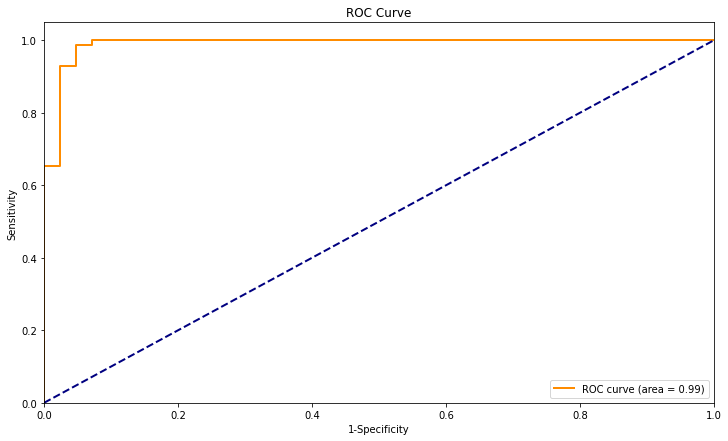

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label=f'ROC curve (area = {roc_auc})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curve')
plt.legend(loc="lower right");

### Summary

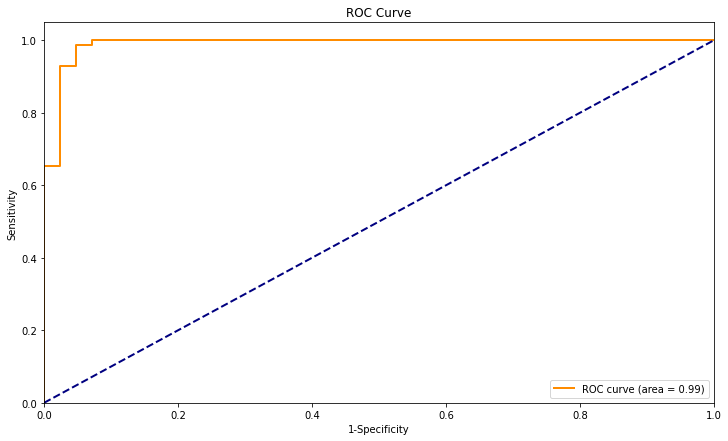

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import xgboost as xgb

from joblib import dump, load


from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()
X = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
y = pd.Series(dataset['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

scaler = StandardScaler()
ct = make_column_transformer((scaler, X_train.columns))
logreg_selector = LogisticRegression(solver='liblinear', penalty='l1', random_state=1)
selector = SelectFromModel(logreg_selector, threshold='1.25*mean')
clf = xgb.XGBClassifier(random_state=1)
pipe = make_pipeline(ct, selector, clf)

params = {}
params['xgbclassifier__learning_rate'] = [0.1, 0.15]
params['xgbclassifier__max_depth'] = [3,5,7]
params['xgbclassifier__n_estimators'] = [75, 100, 125]
params['selectfrommodel__estimator__C'] = [0.1, 1, 10]
params['selectfrommodel__estimator__penalty']= ['l1', 'l2']
params['selectfrommodel__threshold']=['mean', '1.25*mean', '1.5*mean']

grid = GridSearchCV(pipe, params, cv=5, scoring='recall')
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
recall_score(y_test, y_pred)
dump(grid, 'grid.joblib') 


columns = ["TP", "TN", "FP", "FN", "Accuracy", "Prevalence","Sensitivity", "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
df = pd.DataFrame(columns=columns)
df.loc[0] = [0] * len(columns)
df['Threshold'] = 0.5
cm = confusion_matrix(y_test, y_pred)
df['TP'] = cm[1][1]
df['TN'] = cm[0][0]
df['FP'] = cm[0][1]
df['FN'] = cm[1][0]
df['Accuracy'] = np.round(accuracy_score(y_test, y_pred),3)
df['Prevalence'] = np.round(np.mean(y_test),3)
df['Sensitivity'] = np.round(recall_score(y_test, y_pred),3)
df['Specificity'] = np.round(precision_score(y_test, y_pred),3)
df['PPV'] = np.round(df['TP'] / (df['TP'] + df['FP']),3)
df['NPV'] = np.round(df['TN']/(df['TN']+ df['FN']),3)
y_pred = grid.predict_proba(X_test)[:,1]
df['AUC'] = np.round(roc_auc_score(y_test, y_pred), 3) # note: it takes scores, not binary!
df['F1'] = f1_score(y_test, y_pred>0.5)
df.to_csv('evaluation_metrics.csv')

# tpr = sensitivity = recall
# fpr = 1 - specifity = 1 - precision
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = np.round(roc_auc_score(y_test, y_pred),3)
plt.figure(figsize=(12,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label=f'ROC curve (area = {roc_auc})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Next steps

A few ideas of things you could try:

<li> Nested cross-validation </li>
<li> Try additional models </li>
<li> Add interpretability techniques </li>
<li> Deploy in a cloud web-app </li>